# Anomaly Detection

In [13]:
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

from copy import deepcopy

# Creating Sample Data

In [14]:
size = 200

# Creating vectors of features
weight = np.random.normal(loc=70, scale=14, size=size)
height = np.random.normal(loc=174, scale=7, size=size)
power = np.random.normal(loc=200, scale=0.4, size=size)

In [15]:
# Stacking vectors and converting them into dataframe
X = np.column_stack([weight, height, power]) # matrix
df = pd.DataFrame(X, columns=["weight", "height", "power"]) # dataframe

df.head()

,weight,height,power
0,41.964753,183.186599,200.195894
1,70.860885,173.588376,200.241026
2,45.125742,165.606958,199.430103
3,73.822498,174.221694,199.431503
4,93.723376,176.567953,200.038092


# Plotting weight and height

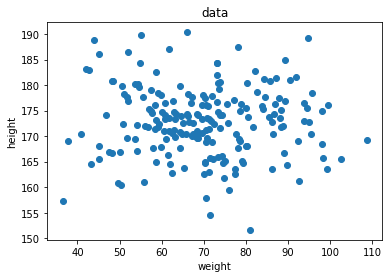

In [16]:
plt.scatter(df.weight, df.height)

plt.title("data")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

# Here We Are Working Only On Weight Column

In [17]:
def gausian_dist(x, s, u):
    """
    Gausian Distribution
    input:
        x - data
        s - standard deviation
        u - mean
    output:
        probability
    """
    return 1 / (np.sqrt(2 * np.pi) * s) * np.exp(-((x - u) ** 2) / (2 * s ** 2))

In [18]:
mean = df.weight.mean() # mean
std = df.weight.std() # standard deviation
std_lower_bound = mean - std # lower bound of std
std_upper_bound = mean + std # upper bound of std

prob = np.array([gausian_dist(x, std, mean) for x in df.weight]) # passing all weight column through gausian_dist function

# Plotting Gausian Distribution Of Our Weight Column

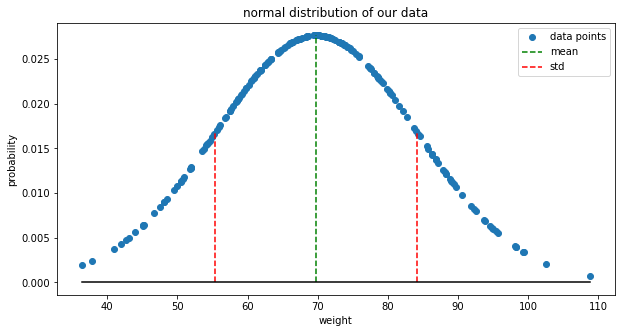

In [19]:
plt.figure(figsize=(10,5))

plt.scatter(df.weight, prob, label="data points") # data points
plt.plot([mean, mean], [0, prob.max()], c="g", label="mean", ls="--") # mean
plt.plot([std_lower_bound, std_lower_bound], [0, gausian_dist(std_lower_bound, std, mean)], c="r", ls="--", label="std") # std lower bound
plt.plot([std_upper_bound, std_upper_bound], [0, gausian_dist(std_upper_bound, std, mean)], c="r", ls="--") # std upper bound
plt.plot([df.weight.min(), df.weight.max()], [0, 0], c="k") # y = 0 line

plt.legend()
plt.title("normal distribution of our data")
plt.xlabel("weight")
plt.ylabel("probability")

plt.show()

In [20]:
eps = gausian_dist(std_lower_bound, std, mean)
points = df.weight[prob > eps] # points between std bounds

points.shape[0] / size * 100 # % of points between std bounds

65.0

##### So as we can see we can chose some small parameter eps that will decide if we should remove point from dataframe or keep it.

# Now We Will Craete Function To Apply Anomaly Detection To Any DataFrame

In [21]:
def anomaly_detection(df, eps=0.1):
    """
    Function that removes anomalies from given data
    input:
        X - data(DataFrame format)
        eps - some small number (0 < eps < 1)
    """
    magic_number = 4883
    
    eps = eps / magic_number # dividing eps=1 by magic_number will result most of the time in returning empty dataframe
    std = df.std(axis=0)
    mean = df.mean(axis=0)
    mult = 1
    df2 = deepcopy(df)
    
    for r in range(df.shape[0]): # iterating through rows
        if mult < eps: 
            df2.drop([r-1], inplace=True) # when condition is met the previous row will be deleted
        mult = 1
        
        for c in range(df.shape[1]): # iterating through columns
            m = mean[c]
            s = std[c]
            mult *= gausian_dist(df.iloc[r,c], s, m)

    if mult < eps:
        df2.drop([r], inplace=True) # code for checking last row
    
    return df2

In [22]:
new_df = anomaly_detection(df, 0.9) # testing function on our dataframe
new_df.shape

(146, 3)

# We Are Creating New Gausian Function For 3d plot

In [23]:
def gausian_dist_3d(x, s, u, x2, s2, u2):
    """
    Gausian Distribution
    input:
        x - data
        s - standard deviation
        u - mean
    output:
        probability
    """
    return (1 / (np.sqrt(2 * np.pi) * s) * np.exp(-((x - u) ** 2) / (2 * s ** 2))) * (1 / (np.sqrt(2 * np.pi) * s2) * np.exp(-((x2 - u2) ** 2) / (2 * s2 ** 2))) #donno if thats correct way xd

# Plotting Original Data

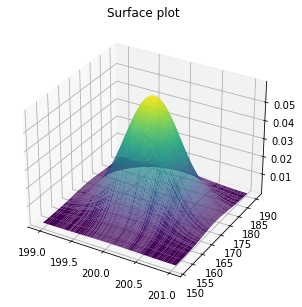

In [24]:
# most of the time weight and height would have correlation so we wouldn't have to sort it,
# but in this case lets do this just for plotting.

X = np.sort(df.power) # power
Y = np.sort(df.height) # height

X, Y = np.meshgrid(X, Y)
Z = gausian_dist_3d(X, X.std(), X.mean(), Y, Y.std(), Y.mean())

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

# Plotting New Data

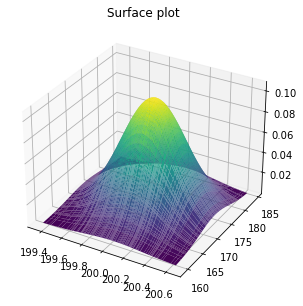

In [25]:
X = np.sort(new_df.power) # power
Y = np.sort(new_df.height) # height

X, Y = np.meshgrid(X, Y)
Z = gausian_dist_3d(X, X.std(), X.mean(), Y, Y.std(), Y.mean())


fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

In [31]:
before = df.height.shape[0] + df.power.shape[0] # orginal data
after = new_df.height.shape[0] + new_df.power.shape[0] # data without anomalies

print("\n**************************************************************")
print(f"As we can see our functino for removing anomalies works correctly\n\n\
Orginal data (height and power) was {before} and now is {after}\nwe removed {before-after} of our data which is {(before-after)/before * 100}% of anomalies")
print("**************************************************************")


**************************************************************
As we can see our functino for removing anomalies works correctly

Orginal data (height and power) was 400 and now is 292
we removed 108 of our data which is 27.0% of anomalies
**************************************************************


The other posible technique would be removing maximal and minimal points in a 20 iteration loop.
This method would work but only if we have perfect normal distribution.
If only the smallest values were anomalies, then we would begin to remove the largest values that we don't want to remove.

If we had Right-hand or Left-hand distribution we could logarithmize our points so it it more symetric data

In this code I made few mistakes like:
- data should have more noise in it(be right or left-hand distributed)
- data should be sorted
- data should be displayed using histogram
- gausian_dist_3d propably works wrong